In [1]:
import jax
import numpy as np
import pandas as pd
import jax.numpy as jnp
import matplotlib.pyplot as plt
import seaborn as sns

from tqdm.auto import tqdm
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from aging.plotting import (
    figure,
    format_plots,
    add_identity,
    PLOT_CONFIG,
    save_factory,
    COLORMAPS,
)
from copy import deepcopy
from operator import or_
from toolz import reduce
from aging.behavior.bio_age_model import (
    fit_model,
)

In [2]:
format_plots()
saver = save_factory(PLOT_CONFIG.save_path / "tmp", tight_layout=False)

In [3]:
def zscore(ser: pd.Series):
    return (ser - ser.mean()) / ser.std()


def demean(ser: pd.Series):
    return ser - ser.mean()


def quantile(n):
    def percentile_(x):
        return x.quantile(n)
    percentile_.__name__ = 'q_{:0.02f}'.format(n)
    return percentile_


def minmax(df):
    return (df - df.min()) / (df.max() - df.min())

In [4]:
def make_plot(age_df, width, height):
    boundaries = np.arange(age_df["labels"].max() + 2) - 0.5
    pal = sns.blend_palette([COLORMAPS.ont_male(255), COLORMAPS.ont_female(255)], as_cmap=True)
    fig = figure(width, height)
    ax = sns.lineplot(
        data=age_df,
        x="true_ages",
        y="bio_ages",
        hue="labels",
        palette=[COLORMAPS.ont_male(255), COLORMAPS.ont_female(255)],
        legend=False,
        zorder=-1,
        lw=0.25,
        err_kws=dict(lw=0),
    )
    perm = np.random.permutation(len(age_df))
    im = ax.scatter(
        age_df["true_ages"].iloc[perm],
        age_df["bio_ages"].iloc[perm],
        c=age_df["labels"].iloc[perm],
        cmap=pal,
        vmin=0,
        vmax=1,
        s=1,
    )
    cb = fig.colorbar(
        mappable=im,
        boundaries=boundaries,
        ax=ax,
        label="Sex",
    )
    cb.set_ticks(range(0, 2))
    cb.set_ticklabels(["Male", "Female"])
    add_identity(ax, c="k", ls="--", zorder=-2)
    ax.set(
        xlabel="Chronological age (weeks)",
        ylabel="Behavioral age (weeks)",
        aspect="equal",
        xlim=(0, 120),
    )
    sns.despine()
    return fig

In [5]:
drop_uuids = [
    'bb6bbfec-9e1c-4abe-91bc-10710b7c39df',
    '4d16f2a6-5df8-4140-a157-a1d453eefc20',
]

In [6]:
def read_male_ontogeny(use_syllables):
    df = pd.read_parquet(
        "/n/groups/datta/win/longtogeny/data/ontogeny/version_11-1/ontogeny_males_raw_counts_matrix_v00.parquet"
    )
    df = df[use_syllables]
    df = df.query('age < 100')

    pth = '/n/groups/datta/win/longtogeny/data/ontogeny/version_11-1/ontogeny_males_mouse_area_df_v00.parquet'
    size_df = pd.read_parquet(pth)

    sizes_col = zscore(size_df.groupby('age')['quant_0.5'].transform(demean))
    sizes_col = sizes_col.loc[df.index]
    df = df.loc[sizes_col.index]
    df = df[use_syllables]
    return df, sizes_col


def read_female_ontogeny(use_syllables):
    df = pd.read_parquet(
        "/n/groups/datta/win/longtogeny/data/ontogeny/version_11-1/ontogeny_females_raw_counts_matrix_v00.parquet"
    )
    df = df[use_syllables]
    df = df.query('age < 100')

    # re-assign 52-wk old animals from their incorrect 8-wk old assignment
    x = ['d6f254af-d55a-427a-96e0-c452a233cbe2', '242bee8e-0ee7-45e7-8a13-678836a4cddb']

    idx = df.index.names
    tmp_df = df.reset_index()
    mask = tmp_df['uuid'].isin(x)
    tmp_df.loc[mask, 'age'] = 52
    df = tmp_df.set_index(idx)

    pth = '/n/groups/datta/win/longtogeny/data/ontogeny/version_11-1/ontogeny_females_mouse_area_df_v00.parquet'
    size_df = pd.read_parquet(pth)

    idx = size_df.index.names
    tmp_df = size_df.reset_index()
    mask = tmp_df['uuid'].isin(x)
    tmp_df.loc[mask, 'age'] = 52
    size_df = tmp_df.set_index(idx)

    sizes_col = zscore(size_df.groupby('age')['quant_0.5'].transform(demean))
    sizes_col = sizes_col.loc[df.index]
    df = df.loc[sizes_col.index]

    df = df[use_syllables]

    age_mapping = {
        93: 94,
        95: 94,
        97: 98,
        98: 98,
        102: 98,
        103: 105,
        105: 105,
        107: 105
    }

    df = df.reset_index(level='age')
    df['age'] = df['age'].map(age_mapping).fillna(df['age'])

    return df.set_index('age', append=True).reorder_levels(idx), sizes_col

In [7]:
keep_syllables = np.loadtxt('/n/groups/datta/win/longtogeny/data/ontogeny/version_11/to_keep_syllables_raw.txt', dtype=int)

In [8]:
df, sizes_col = read_male_ontogeny(keep_syllables)
female_df, female_sizes_col = read_female_ontogeny(keep_syllables)
df = pd.concat([df, female_df])

age = jnp.array(df.index.get_level_values("age"))
syllable_counts_jax = jnp.array(df.astype(float))

label_encoder = OneHotEncoder(sparse_output=False, dtype=np.float32)
sex_id = label_encoder.fit_transform(
    np.hstack([np.zeros(len(df) - len(female_df)), np.ones(len(female_df))])[:, None]
).T

sort_idx = np.argsort(syllable_counts_jax.mean(0))[::-1]

df['sex'] = np.where(sex_id == 1)[0]
df = df.set_index('sex', append=True)

labels = LabelEncoder().fit_transform(np.hstack([np.zeros(len(df) - len(female_df)), np.ones(len(female_df))]))

In [9]:
features = {
    "ages": age,  # models >= 1
    "counts": syllable_counts_jax + 1,  # models >= 1
    "sizes": pd.concat([sizes_col, female_sizes_col]).to_numpy(),  # models > 1
    "mice": sex_id,
}

log_scale_sd = True
log_age = True

if log_scale_sd:
    age_sd = 0.105
else:
    age_sd = 0.04

if not log_age:
    age_sd = 2.25

hypparams = {
    "log_age": log_age,
    "min_age": 2,
    "max_age": 125,
    "age_sd": age_sd,
    "n_age_samples": 1000,
    "n_splines": 4,
    "n_syllables": syllable_counts_jax.shape[1],
    "n_development_splines": 4,
    "scale": 400,
    "normalize_by_softmax": True,
    "n_keep_sylls": 25,
    "n_sessions": len(syllable_counts_jax),
    "n_animals": len(sex_id),
    "lr": 0.25,
    "n_opt_iter": 620,
    "log_scale_sd": log_scale_sd,
}

In [10]:
residuals = pd.concat([
    pd.read_parquet('/n/groups/datta/win/longtogeny/data/ontogeny/version_11-1/beh_age_df/ont_residuals_male.parquet'),
    pd.read_parquet('/n/groups/datta/win/longtogeny/data/ontogeny/version_11-1/beh_age_df/ont_residuals_female.parquet')
])

In [11]:
total_avg_residual = residuals.abs().mean().iloc[0]
total_avg_residual

11.694789323201565

In [12]:
mae = residuals.abs().median().iloc[0]
mae

9.744186434966167

## Run optimization loop

In [13]:
residual_map = {}
for i in tqdm(np.logspace(-1.3, 0, 11)):
    hyp_copy = deepcopy(hypparams)
    hyp_copy['age_sd'] = i
    mdl = fit_model(features, hyp_copy, 5, return_loss_on_error=True)
    if len(mdl) == 1:
        print(hypparams['n_opt_iter'] - np.isnan(mdl['loss']).sum())
        continue
    mdl_residuals = mdl['true_ages'] - mdl['bio_ages']
    mdl_residuals = mdl_residuals[mdl['true_ages'] > 50]
    avg_mdl_residuals = np.median(np.abs(mdl_residuals))
    residual_map[i] = avg_mdl_residuals
residual_map = pd.Series(residual_map)

  0%|          | 0/11 [00:00<?, ?it/s]

[None]

findfont: Font family ['cursive'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'cursive' not found because none of the following families were found: Apple Chancery, Textile, Zapf Chancery, Sand, Script MT, Felipa, Comic Neue, Comic Sans MS, cursive
findfont: Font family ['Liberation Sans'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Liberation Sans'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Liberation Sans'] not found. Falling back to DejaVu Sans.


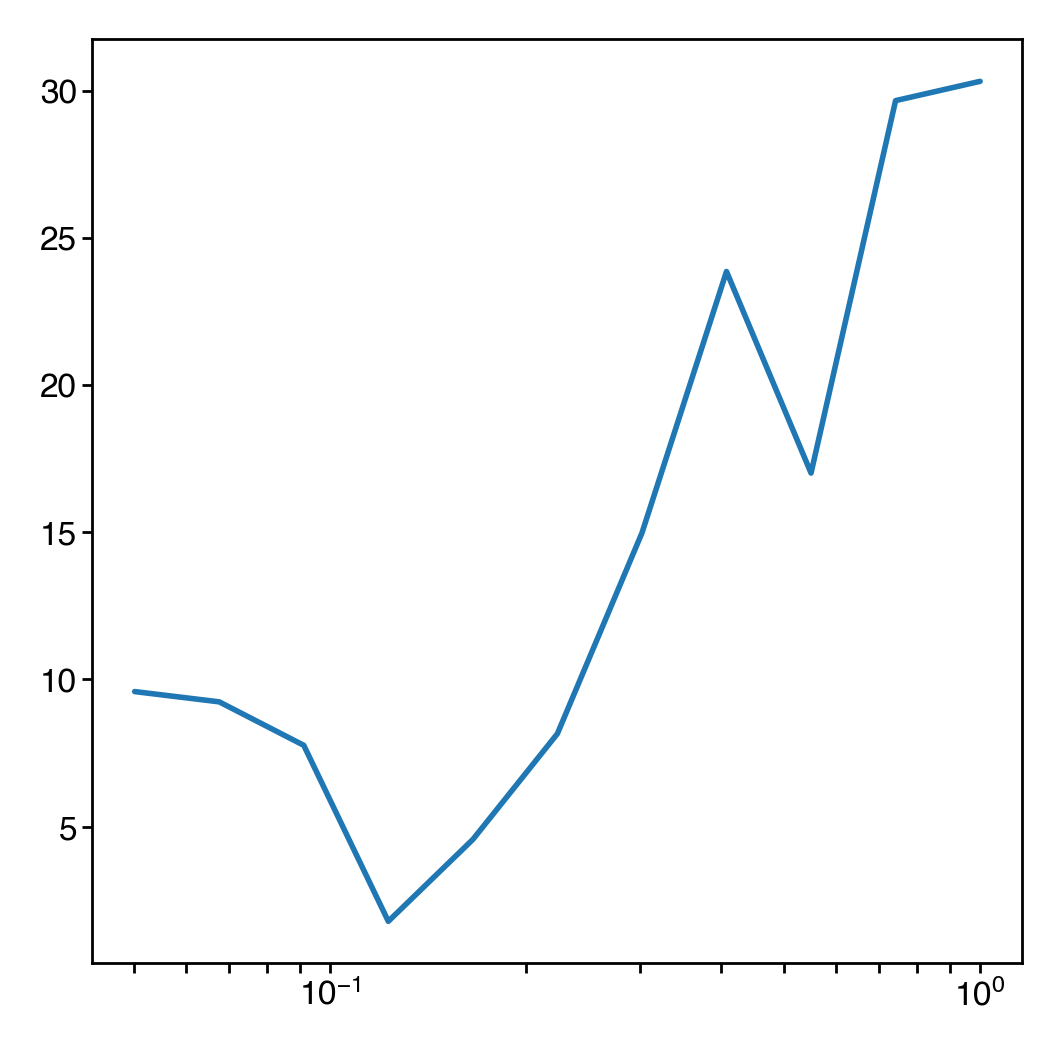

In [14]:
loss = (residual_map - mae).abs()
ax = loss.plot()
ax.set(xscale='log')

In [15]:
loss

0.050119     9.586164
0.067608     9.236828
0.091201     7.760498
0.123027     1.780026
0.165959     4.561569
0.223872     8.155626
0.301995    14.975555
0.407380    23.859058
0.549541    17.009731
0.741310    29.664658
1.000000    30.320591
dtype: float32

In [16]:
hypparams['age_sd'] = loss.idxmin()
hypparams['age_sd']

0.12302687708123815

## Get males vs females

In [17]:
mdl = fit_model(features, hypparams, 5, return_loss_on_error=True)

if len(mdl) == 1:
    print(hypparams['n_opt_iter'] - np.isnan(mdl['loss']).sum())

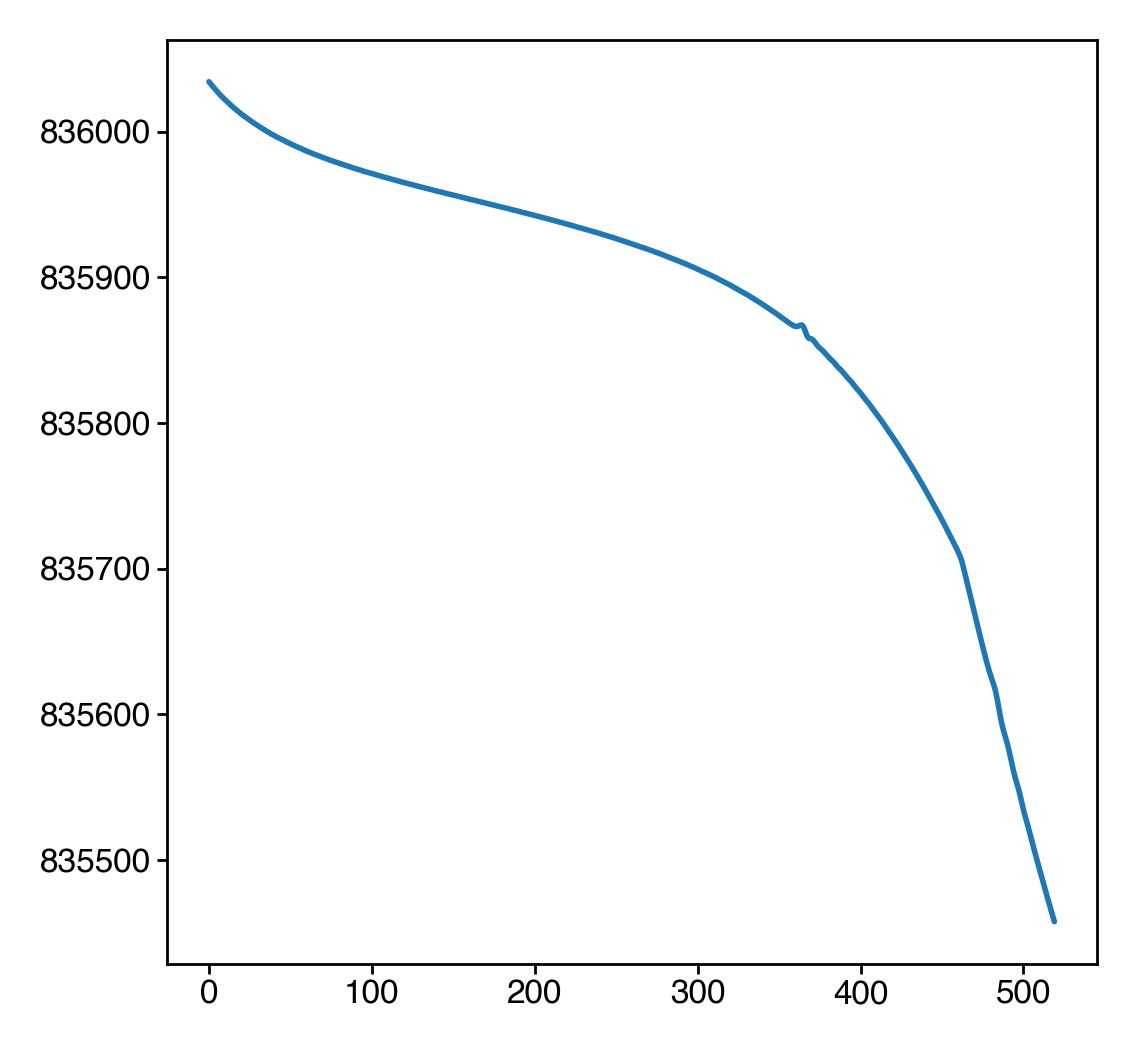

In [18]:
plt.plot(mdl['loss'][100:])

## Make ontogeny sex age plot

In [19]:
age_df = pd.DataFrame(
    dict(bio_ages=mdl["bio_ages"], true_ages=mdl["true_ages"], labels=labels), index=df.index
)

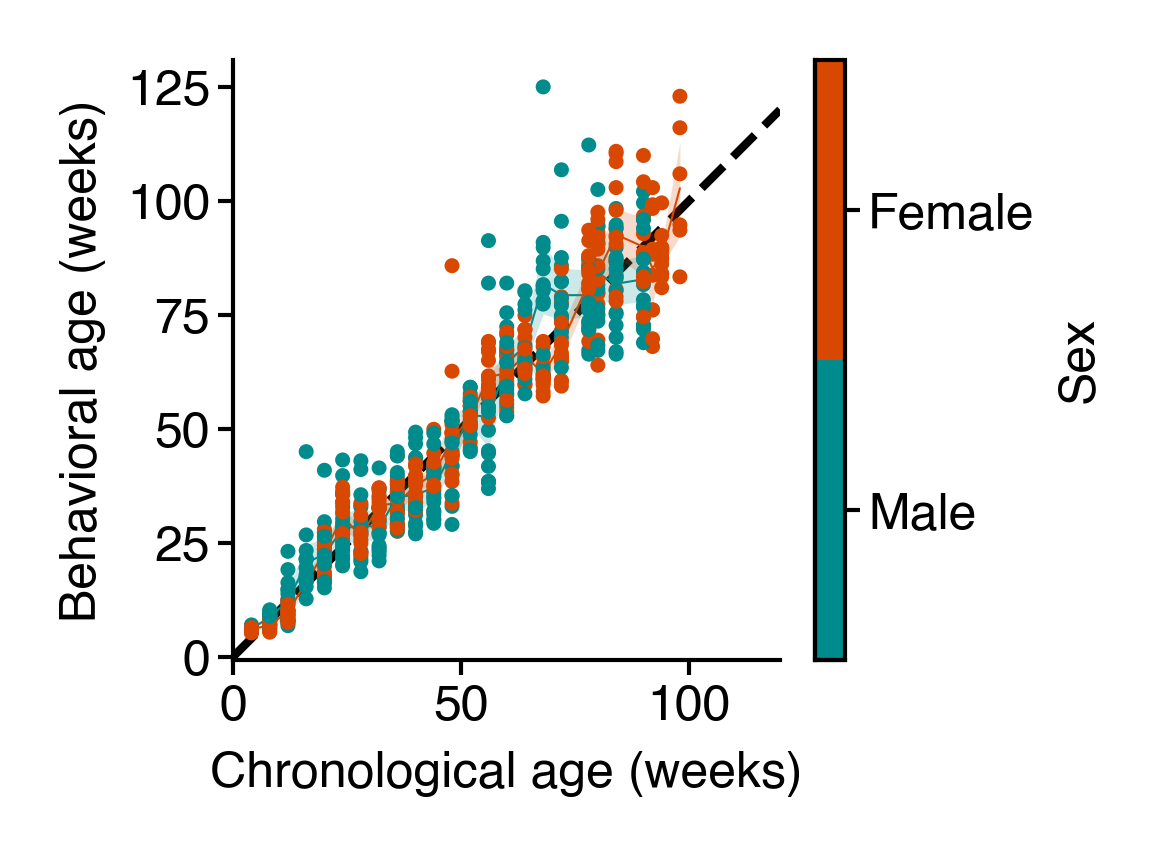

In [20]:
fig = make_plot(age_df, 1.5, 1.3)
saver(fig, "ontogeny-sex-chron-vs-beh-age-all-timepoints");

# Plots and analysis

## Predicted syllables plot

In [21]:
# male is blue, female is orange
example_mice = [0, 1]

mask = []
for m in example_mice:
    mask.append(labels == m)
mask = reduce(or_, mask)

sylls = [0, 1, 3, 5, 6, 8, 10, 14, 15, 19, 23]
fig, ax = plt.subplots(len(sylls), 3, figsize=(3, len(sylls)), sharex=True, dpi=900)

true_age = mdl["true_ages"][mask]
bio_age = mdl["bio_ages"][mask]
counts = mdl["counts"][mask]
pred_counts = mdl["predicted_counts"][mask]

pal = sns.blend_palette([COLORMAPS.ont_male(255), COLORMAPS.ont_female(255)], as_cmap=True)

for a, syll, i in zip(ax, map(lambda i: int(sort_idx[i]), sylls), sylls):
    max_counts = max([counts[:, syll].max(), pred_counts[:, syll].max()]) * 1.05
    a[0].scatter(true_age, counts[:, syll], s=2.5, c=labels[mask], cmap=pal, vmax=1, vmin=0, rasterized=True)
    a[0].set(title=f"Idx {i} Syllable {df.columns[syll]}", ylabel="Counts", xlabel="Chron. age (weeks)", ylim=(0, max_counts))

    a[2].scatter(bio_age, pred_counts[:, syll], s=2.5, c=labels[mask], cmap=pal, vmax=1, vmin=0, rasterized=True)
    a[2].set(ylabel="Pred. counts", xlabel="Beh. age (weeks)", ylim=(0, max_counts), yticklabels=[])

    a[1].scatter(bio_age, counts[:, syll], s=2.5, c=labels[mask], cmap=pal, vmax=1, vmin=0, rasterized=True)
    a[1].set(ylabel="Counts", xlabel="Beh. age (weeks)", ylim=(0, max_counts), yticklabels=[])

sns.despine()
fig.tight_layout()

saver(fig, "sex-ontogeny-true-vs-predicted-counts", dpi=300);

In [22]:
list(mdl['params'])

['bio_basis_weights', 'development_weights', 'individual_biases', 'size_slope']

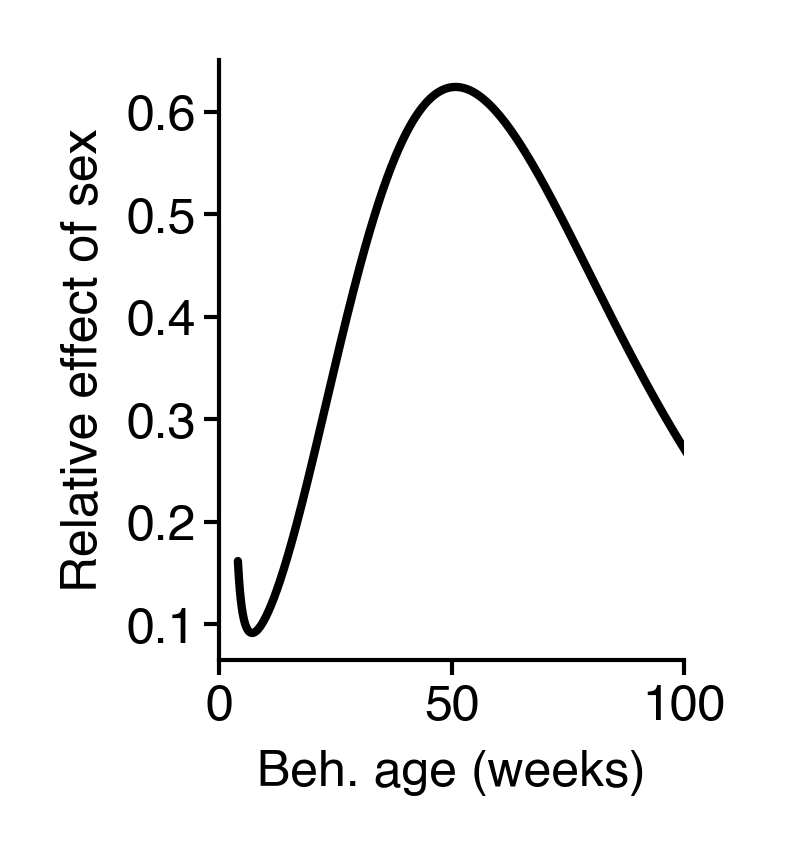

In [23]:
comps = mdl['init_components']

x = mdl['params']['development_weights']
dev = np.exp(x @ comps.bases['development']).squeeze()
_ages = comps.age_unnormalizer(comps.age_samples)
dev = np.where(_ages < 4, np.nan, dev)

fig = figure(1, 1.3)
ax = fig.gca()
ax.plot(_ages, dev, color='k')
plt.xlim(0, 100)
# plt.ylim(0, None)
plt.xlabel("Beh. age (weeks)")
plt.ylabel("Relative effect of sex")
sns.despine()
saver(fig, "ontogeny-effect-of-sex");

## Second try - median

In [13]:
from itertools import product
import random

In [14]:
random.seed(1)
resid_df = []

options = list(product(np.linspace(0.12, 0.2, 8 * 5 + 1), np.arange(100, 425, 50)))
random.shuffle(options)

for i, j in tqdm(options):
    hyp_copy = deepcopy(hypparams)
    hyp_copy['age_sd'] = i
    hyp_copy['scale'] = j
    mdl = fit_model(features, hyp_copy, 5, return_loss_on_error=True)
    if len(mdl) == 1:
        print(hypparams['n_opt_iter'] - np.isnan(mdl['loss']).sum())
        continue
    mdl_residuals = mdl['true_ages'] - mdl['bio_ages']
    mdl_residuals = mdl_residuals[mdl['true_ages'] > 50]
    avg_mdl_residuals = np.median(np.abs(mdl_residuals))
    resid_df.append({
        'residual': avg_mdl_residuals,
        'sd': i,
        'scale': j,
    })
resid_df = pd.DataFrame(resid_df).round(4)

  0%|          | 0/287 [00:00<?, ?it/s]

<Axes: xlabel='sd', ylabel='scale'>

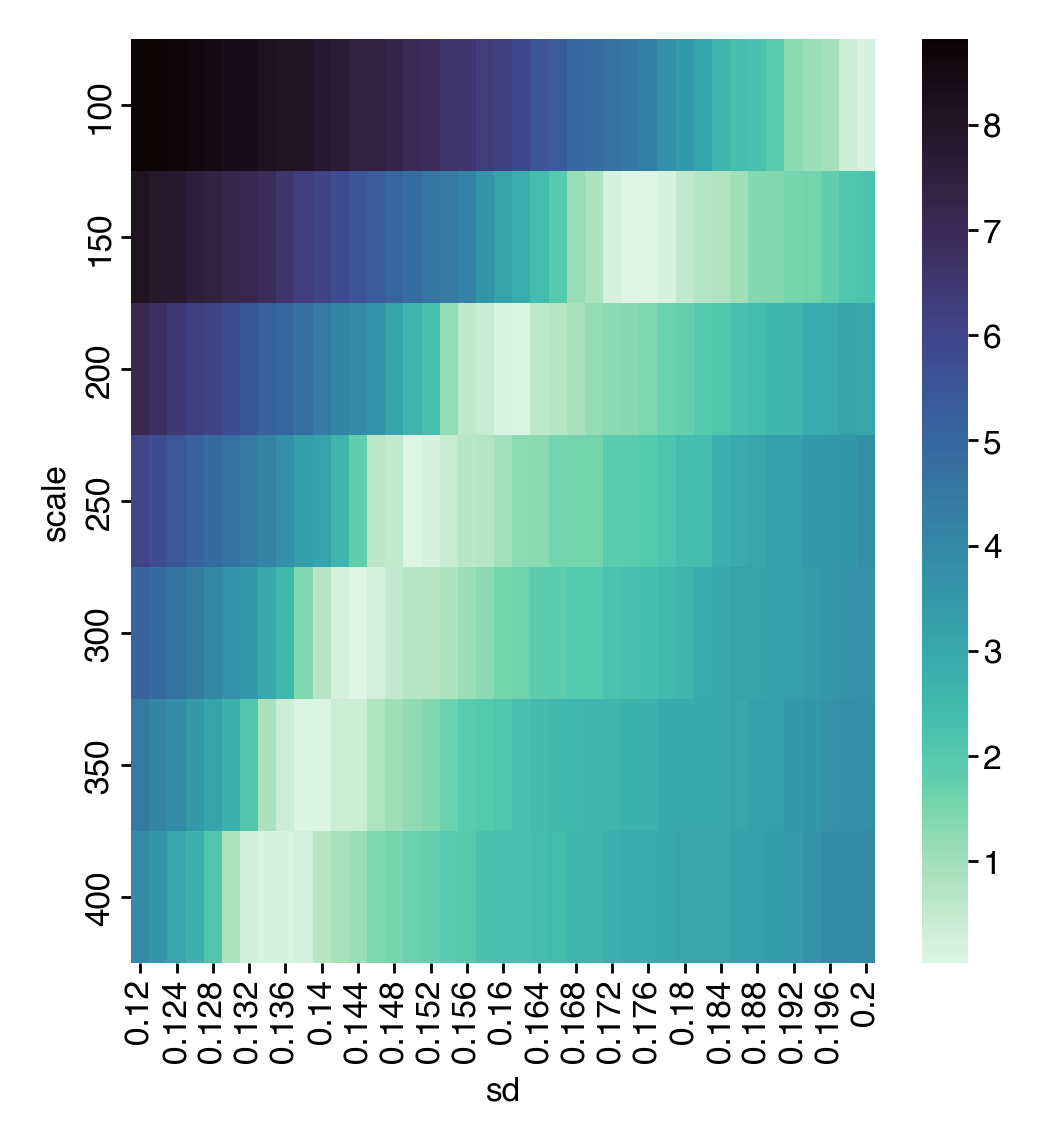

In [15]:
sns.heatmap(
    data=(
        resid_df.pivot_table(index="scale", columns="sd", values="residual") - mae
    ).abs(),
    cmap="mako_r",
)

In [16]:
pt = resid_df.pivot_table(index="scale", columns="sd", values="residual") - mae
pt = pt.abs()

<Axes: xlabel='sd'>

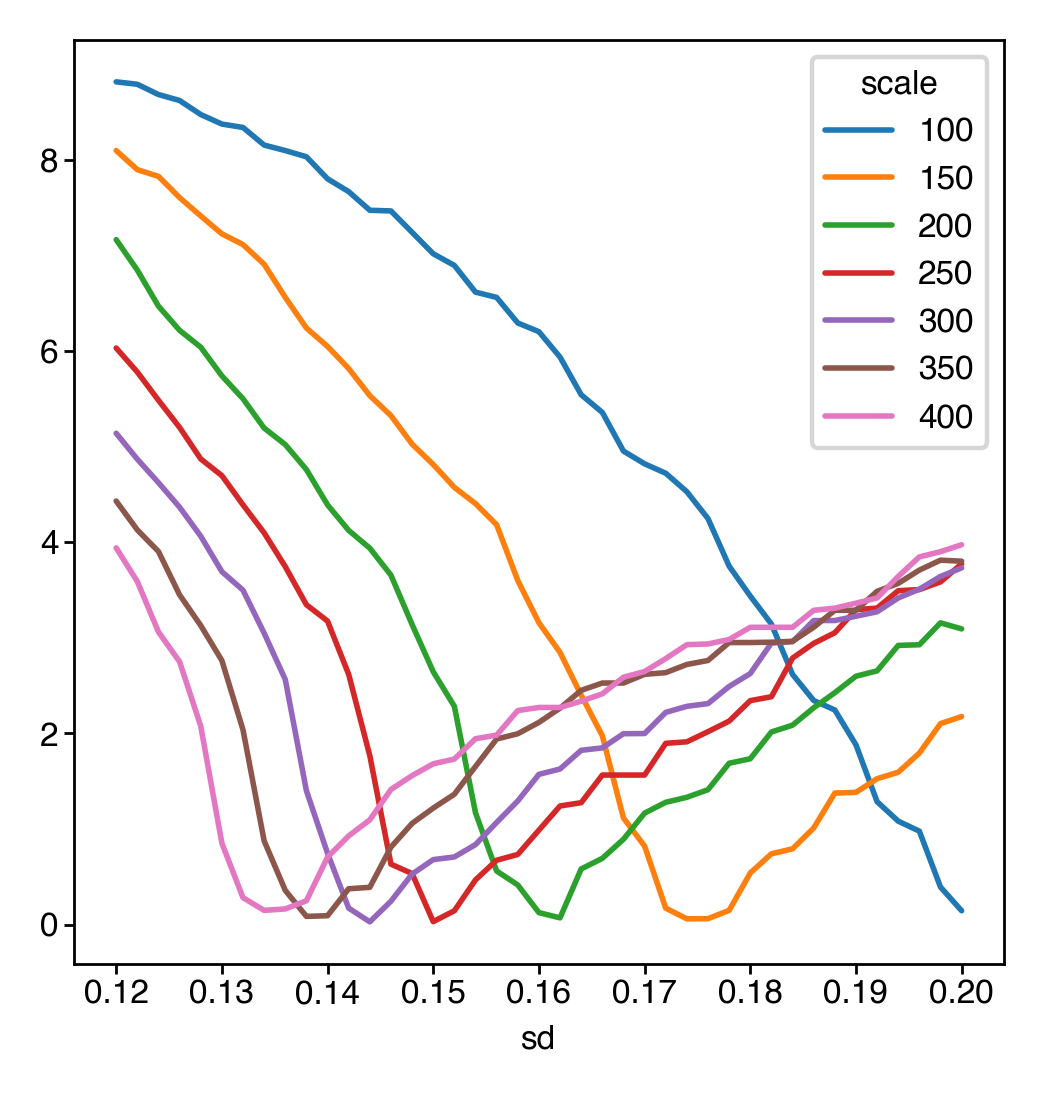

In [27]:
pt.T.plot()

<Axes: xlabel='sd'>

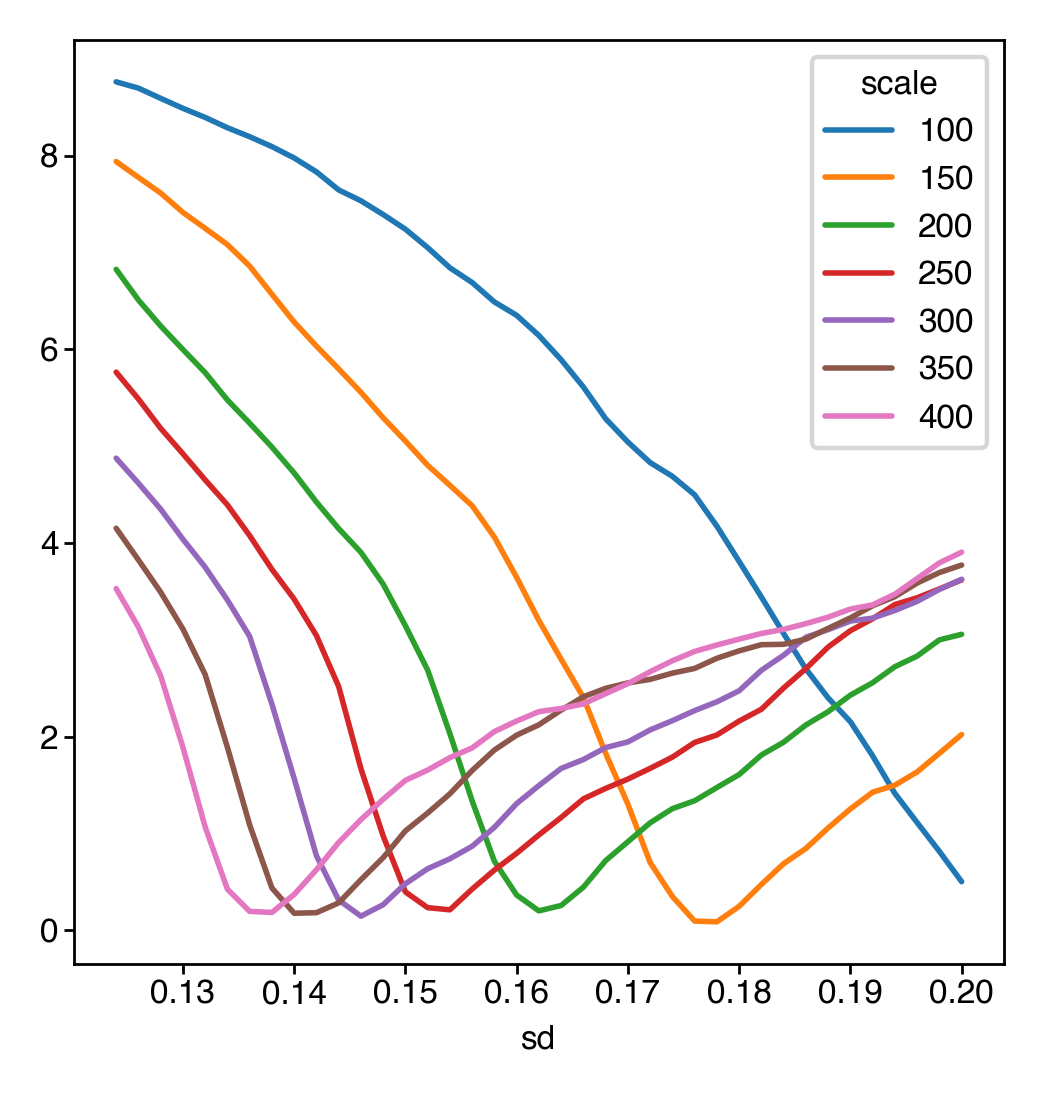

In [29]:
pt.T.rolling(3).mean().plot()

In [30]:
pt.T.rolling(3).mean().min()

scale
100    0.504187
150    0.089462
200    0.202662
250    0.213638
300    0.147738
350    0.178095
400    0.186438
dtype: float64

In [17]:
pt.to_parquet('/n/scratch/users/w/wg41/tmp-bambi-hyp-scan-via-residuals.parquet')

In [18]:
pt.min()

sd
0.120    3.940786
0.122    3.589186
0.124    3.061786
0.126    2.749286
0.128    2.076586
0.130    0.851486
0.132    0.280787
0.134    0.147986
0.136    0.162813
0.138    0.084987
0.140    0.092113
0.142    0.171387
0.144    0.028013
0.146    0.243814
0.148    0.527514
0.150    0.029986
0.152    0.144114
0.154    0.466814
0.156    0.559787
0.158    0.414086
0.160    0.124287
0.162    0.069613
0.164    0.581214
0.166    0.692214
0.168    0.891913
0.170    0.820686
0.172    0.171287
0.174    0.059286
0.176    0.061187
0.178    0.147914
0.180    0.539114
0.182    0.739914
0.184    0.791914
0.186    1.009713
0.188    1.375013
0.190    1.382713
0.192    1.285486
0.194    1.081487
0.196    0.976686
0.198    0.391987
0.200    0.143887
dtype: float32

In [19]:
pt.min().idxmin()

0.144

In [20]:
pt[pt.min().idxmin()].idxmin()

300

In [21]:
pt.T.min()

scale
100    0.143887
150    0.059286
200    0.069613
250    0.029986
300    0.028013
350    0.084987
400    0.147986
dtype: float32

In [22]:
pt.T.idxmin()

scale
100    0.200
150    0.174
200    0.162
250    0.150
300    0.144
350    0.138
400    0.134
dtype: float64

In [70]:
hyp_copy = deepcopy(hypparams)
hyp_copy['age_sd'] = 0.173
hyp_copy['scale'] = 150
mdl = fit_model(features, hyp_copy, 5, return_loss_on_error=True)

if len(mdl) == 1:
    print(hypparams['n_opt_iter'] - np.isnan(mdl['loss']).sum())

In [71]:
age_df = pd.DataFrame(
    dict(bio_ages=mdl["bio_ages"], true_ages=mdl["true_ages"], labels=labels), index=df.index
)

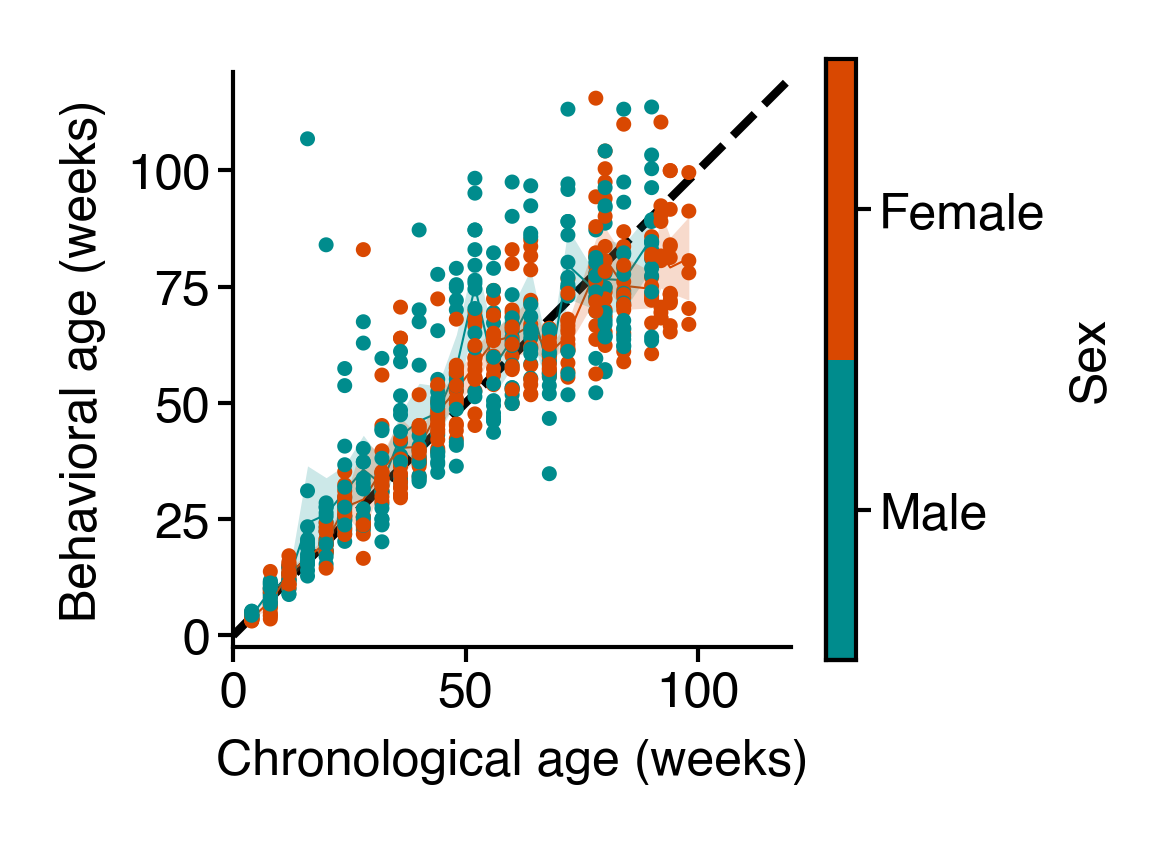

In [72]:
fig = make_plot(age_df, 1.5, 1.3)

In [41]:
pt = resid_df.pivot_table(index="scale", columns="sd", values="residual") - mae

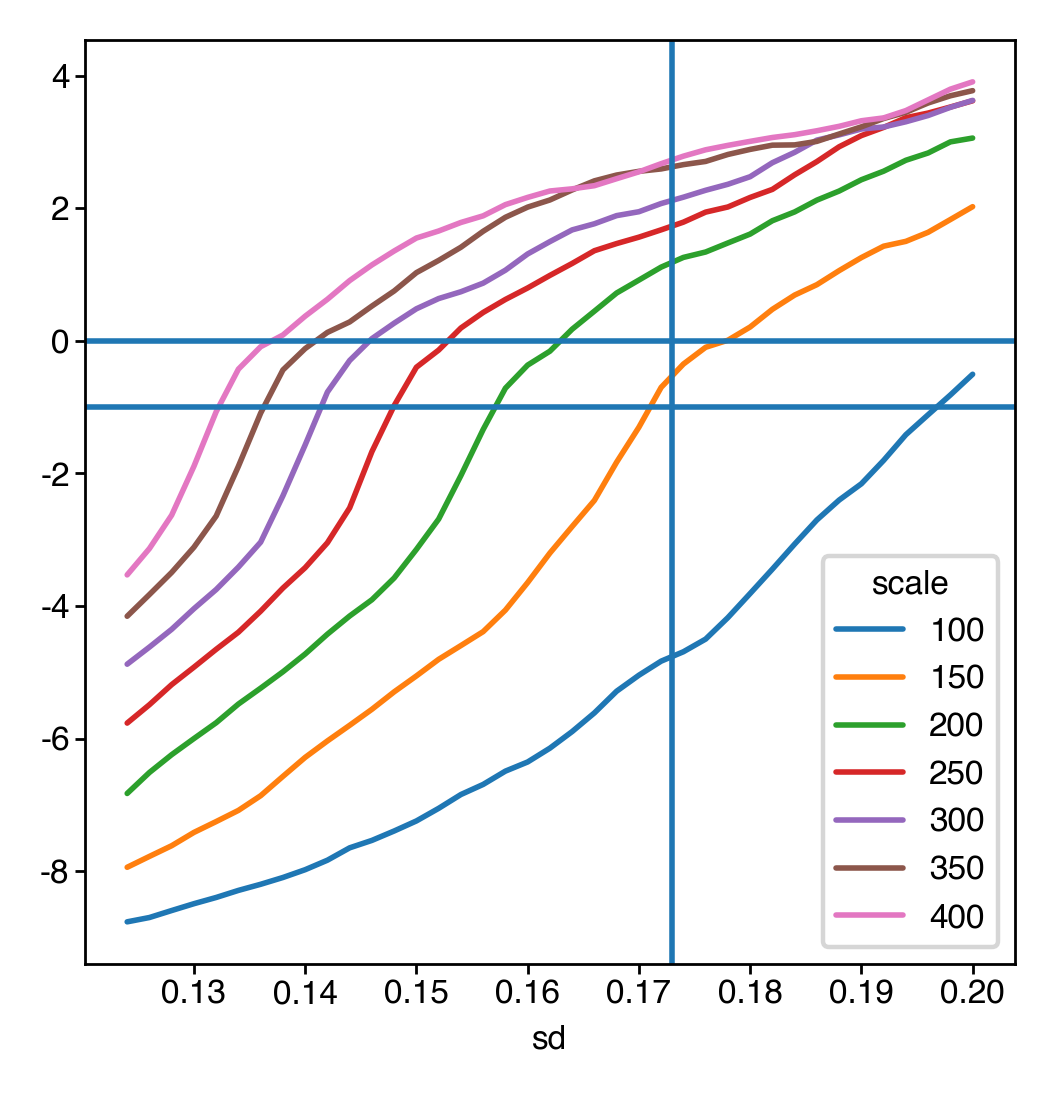

In [60]:
ax = pt.T.rolling(3).mean().plot()
ax.axhline(0)
ax.axhline(-1)
ax.axvline(0.173)